<a href="https://colab.research.google.com/github/MullerBig/API-RESTful-Futebol/blob/master/Rede_Neural_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim


In [35]:
transform = transforms.ToTensor()  # definindo a conversão de imagem para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)  # Carrega o conjunto de treino
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)  # Cria um buffer para permutar os dados

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform)  # Carrega o conjunto de validação
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)  # Cria um buffer para permutar os dados


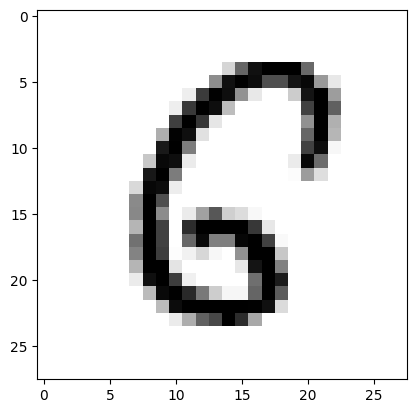

In [36]:
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')

In [37]:
print(imagens[0].shape) #verifica as dimensões do tensor de cada imagem
print(etiquetas[0].shape) #verifica as dimensões do tensor de cada da etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [38]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) # camada de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128, 64)    # camada interna 1, 128 neurônios que se ligam a 64
        self.linear3 = nn.Linear(64, 10)     # camada interna 2, 64 neurônios que se ligam a 10
        # para a camada de saída não é necessário definir nada pois só precisamos pegar o output da camada interna 2

    def forward(self, X):
        X = F.relu(self.linear1(X)) # função de ativação da camada de entrada para a camada 1
        X = F.relu(self.linear2(X)) # função de ativação da camada interna 1 para a camada interna 2
        X = self.linear3(X)         # função de ativação da camada interna 2 para a camada de saída, nesse caso f(x) = x
        return F.log_softmax(X, dim=1) # dados utilizados para calcular a perda


In [39]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 10)

    def forward(self, X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1)

def treino(modelo, trainloader, device):
    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5)
    inicio = time()
    criterio = nn.NLLLoss()
    EPOCHS = 10
    modelo.train()

    for epoch in range(EPOCHS):
        perda_acumulada = 0

        for imagens, etiquetas in trainloader:
            imagens = imagens.view(imagens.shape[0], -1)
            otimizador.zero_grad()
            output = modelo(imagens.to(device))
            perda_instantanea = criterio(output, etiquetas.to(device))
            perda_instantanea.backward()
            otimizador.step()
            perda_acumulada += perda_instantanea.item()

        else:
            print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))

    print("\nTempo de treino (em minutos) =", (time()-inicio)/60)


In [40]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0
    for imagens, etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1, 784)
            with torch.no_grad():
                logps = modelo(img.to(device))

            ps = torch.exp(logps)
            probab = list(ps.cpu().numpy()[0])
            etiqueta_pred = probab.index(max(probab))
            etiqueta_certa = etiquetas.numpy()[i]
            if(etiqueta_certa == etiqueta_pred):
                conta_corretas += 1
            conta_todas += 1

    print("Total de imagens testadas =", conta_todas)
    print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))


In [41]:
modelo = Modelo()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)


Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)